In [49]:
import fsps
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import corner
import emcee
from scipy.stats import norm
%matplotlib inline

In [2]:
# load data file
data = np.genfromtxt('ps5_data.txt', unpack = True)

## Problem 4
### (a)
Make a plot showing SFR(FUV) vs. M* for galaxies in the sample.

For this problem, I will begin by using the equation from Kennicutt & Evans 2012 to find the star formation rate using my previously derived value of C(FUV):  $\dot{M}_* \ [M_{\odot} yr^{-1}] \ = \ log(L_{FUV}) - log(C_{FUV})$. I will convert the apparent FUV magnitudes into luminosities using the same equations as in problem 1.

In [45]:
#find SFR
#toss out all 99.99s, AKA 'no data' tags
no_data = np.where(data[11]!=99.99)[0]

c = 2.99792458e18 # ang/s
#convert distance to cm
dist = data[7][no_data]*(1e6)*(3.085677581467192e19) # in cm
#AB magnitude zero point
m_ab = -2.5*np.log10(3631*10**(-23))

#find f_fuv, same equation as in problem 1
f_fuv = 10**(-0.4*(m_ab + data[11][no_data]))

#find l_luv, same equation as in problem 1
fuv_freq = c / 1535.1
l_fuv = 4.*np.pi*(dist**2)*f_fuv*fuv_freq

#use Kennicutt equation from problem 1 to find the log(SFR_FUV)
m_dot = np.log10(l_fuv) - 43.55141484 # value of log(C) derived in problem 1

Now that I have SFR(FUV) values for each galaxy, I need to calculate M* from the linear relation in problem 2 between L(b) and Mass. From problem 2, the linear relationship between mass and b luminosity has a slope of 7.14924197946e-21 and a y-intercept of 0.617674543806.

In [199]:
#find f_fuv, same equation as in problem 1
f_B = 10**(-0.4*(m_ab + data[8][no_data]))

#find l_B, same equation as in problem 2
L_B = 4.*np.pi*(dist**2)*f_B

#from problem 2
slope_lb = 7.14924197946e-21
int_lb = 0.617674543806
masses_lb = L_B*slope_lb + int_lb

In [200]:
#gaussian uncertainties of mass that reflect the gaussian uncertainties in the b-mags*slope
mass_errors = np.random.normal(loc = 0.0, scale = 0.1, size = np.size(data[8][no_data]))*slope*0.4

sfr_errors = data[12][no_data]
for i in range(len(sfr_errors)):
    if sfr_errors[i] == 99.99:
        sfr_errors[i] = 0.5
sfr_errors = sfr_errors*0.4 #from the equation that converts magnitudes into fluxes

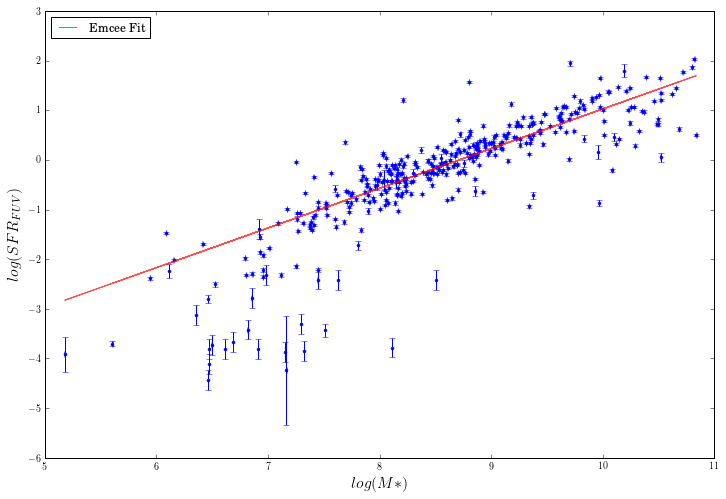

In [201]:
#test emcee output
test_y = 0.8*np.log10(masses_lb) - 6.97

#plot of log (SFR) vs. log(mass)
fig, ax = plt.subplots(figsize = (12,8))
#plot data with errorbars
ax.errorbar(np.log10(masses_lb),m_dot, yerr = sfr_errors, xerr= mass_errors, fmt = '.')
#plot emcee fit
ax.plot(np.log10(masses_lb), test_y, color = 'red', alpha = 0.7, label = 'Emcee Fit')
ax.set_ylabel('$log(SFR_{FUV})$', fontsize = 16)
ax.set_xlabel('$log(M*)$', fontsize = 16)
plt.legend(loc =2)
plt.show()

# 4 (b)
Use emcee to fit a simple functional form to the linear-linear or log-log data from part (a). Make the usual diagnostic plots and overplot draws from your posterior on the real data.

In [58]:
def lnprob(m_b,x,y, sigma_y):
    """Function to feed to emcee that computes the ln(P) of the posterior, assuming flat priors.
    It calculates the y values from the guessed m and b values and compares them to the raw fake
    data y values, another, more simple and straighforward method of determining p(m,b|x,y)
    """
    y_test = m_b[0]*x + m_b[1]
    p = np.sum(norm.logpdf(y_test, loc = y, scale = sigma_y))
    return p

In [184]:
text_size = 16
n_walkers = 200
ndim = 2
initial = [np.random.rand(ndim) for i in range(n_walkers)]
sampler = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[np.log10(masses_lb), m_dot, sfr_errors])

#burn in, then reset sampler
pos1, prob, state = sampler.run_mcmc(initial, 500)
sampler.reset()
sampler.run_mcmc(pos1, 1000, rstate0 = state)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

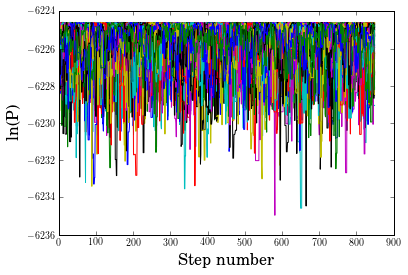

In [156]:
#plot ln(P) vs. step number for emcee sampler
plt.figure(1)
[plt.plot(sampler.lnprobability[i,150:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = text_size)
plt.ylabel(r'ln(P)', fontsize = text_size)
#plt.savefig("lnp_step_emcee.png", dpi=300)

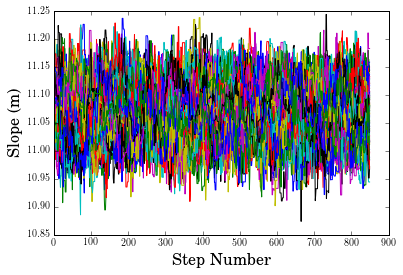

In [157]:
#m vs. Step Number
plt.figure(2)
[plt.plot(sampler.chain[i,150:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Slope (m)', fontsize = text_size)

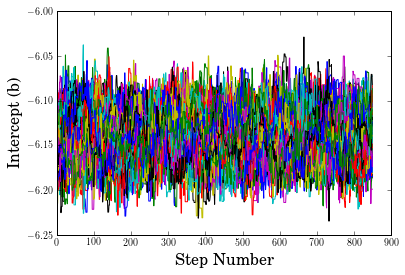

In [158]:
#b vs. step Number, snippet borrowed from lecture
plt.figure(3)
[plt.plot(sampler.chain[i,150:,1]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Intercept (b)', fontsize = text_size)

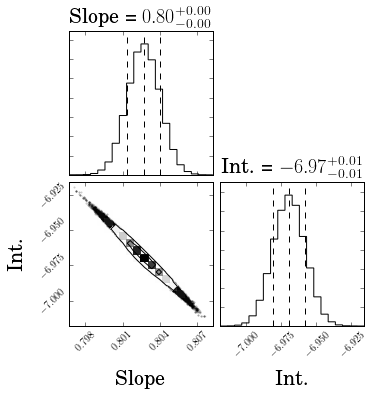

In [186]:
plt.figure(4)
corner.corner(sampler.flatchain[6000:,:], labels = [r'Slope',r'Int.'], show_titles = True,\
              plot_contours = True,quantiles = [.16, .5, .84], label_kwargs={"fontsize": 20},title_kwargs={"fontsize": 20})
plt.show()

# 4 (c)
Repeat parts (a) and (b) only for metallicity instead of stellar mass.

We can repeat the steps taken in problem 3, in order to convert the b-band apparent magnitude into an absolute magnitude, then into a metallicity using the equation from Berg et al 2012.
$$12 + log(O/H) = (6.59 \pm 0.32) + (-0.08 \pm 0.03)M_B $$

In [123]:
#use distance modulus to get absolute magnitude from apparent
abs_mags = data[8][no_data] - 5*np.log10(data[7][no_data]*1e6) + 5

In [124]:
#use Equation 8 from Berg et al. 2012 to get 12 + log10(O/H)
o_h = 6.59 - 0.08*abs_mags

In [125]:
#find errors on metallicity
o_h_errors = np.random.normal(loc = 0.0, scale = 0.1, size = np.size(data[8][no_data]))*0.08

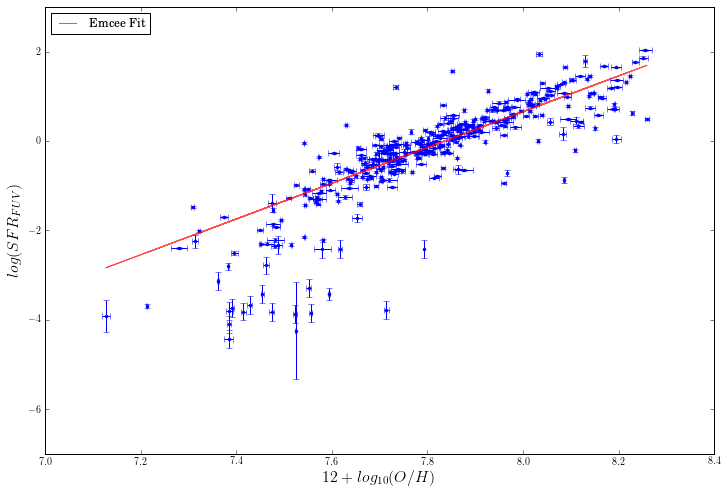

In [172]:
#plot emcee output
test_y2 = 4.01*o_h - 31.42

#plot of log (SFR) vs. 12 + log10(O/H)
fig1, ax1 = plt.subplots(figsize = (12,8))
#plot data with errorbars
ax1.errorbar(o_h,m_dot, yerr = sfr_errors, xerr= o_h_errors, fmt = '.')
#plot emcee fit
ax1.plot(o_h, test_y2, color = 'red', alpha = 0.7, label = 'Emcee Fit')
ax1.set_ylabel('$log(SFR_{FUV})$', fontsize = 16)
ax1.set_xlabel('$12 + log_{10}(O/H)$', fontsize = 16)
ax1.set_ylim(-7,3)
ax1.set_xlim(7, 8.4)
plt.legend(loc =2)
plt.show()

Now I will perform emcee on the metallicity SFR data to derive a linear relationship.

In [135]:
n_walkers2 = 200
ndim2 = 2
initial2 = [np.random.rand(ndim2) for i in range(n_walkers2)]
sampler2 = emcee.EnsembleSampler(n_walkers2, ndim2, lnprob, args=[o_h, m_dot, sfr_errors])

#burn in, then reset sampler
pos2, prob2, state2 = sampler2.run_mcmc(initial2, 500)
sampler2.reset()
sampler2.run_mcmc(pos2, 1000, rstate0 = state2)

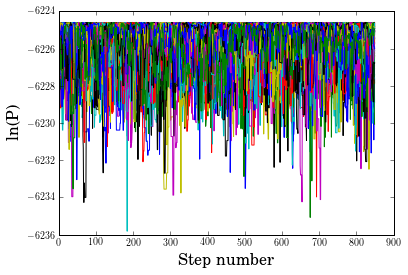

In [138]:
#plot ln(P) vs. step number for emcee sampler
plt.figure(5)
[plt.plot(sampler2.lnprobability[i,150:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = text_size)
plt.ylabel(r'ln(P)', fontsize = text_size)
plt.show()

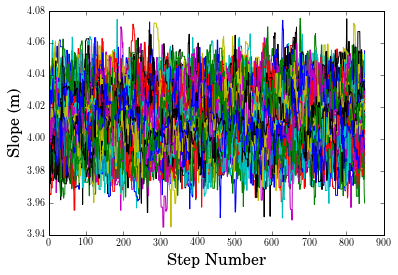

In [139]:
#m vs. Step Number
plt.figure(6)
[plt.plot(sampler2.chain[i,150:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Slope (m)', fontsize = text_size)
plt.show()

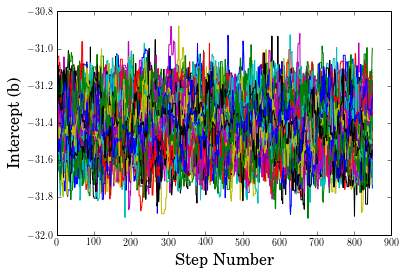

In [140]:
#b vs. step Number, snippet borrowed from lecture
plt.figure(7)
[plt.plot(sampler2.chain[i,150:,1]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Intercept (b)', fontsize = text_size)
plt.show()

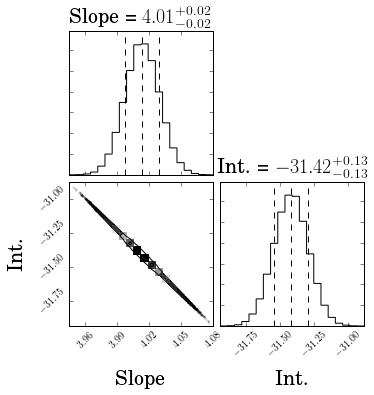

In [175]:
plt.figure(8)
corner.corner(sampler2.flatchain[6000:,:], labels = [r'Slope',r'Int.'], show_titles = True,\
              plot_contours = True, quantiles = [.16, .5, .84],label_kwargs={"fontsize": 20},title_kwargs={"fontsize": 20})
plt.show()

# Problem 5
Briefly comment on limitations of the above analysis. Pay particular attention to what assumptions you made in your analysis might be problematic and suggest how they might be remedied. Along the same lines, what data would improve determinations of the SFR-mass or SFR-metallicity relationships for this sample and why?

There are multiple assumptions made throughout this analysis that may have introduced significant uncertainty. First, we assumed a constant star formation history. It is very likely that the galaxys in the sample had a variety of star formation histories that were not constant. This would have limited our ability to apply/extrapolate the simple luminosity/SFR relation to all values of luminosity.

Additionally, I didn't assume any dust attenuation curve, which likely would affect the result considering that I am using B magnitude and FUV which are especially sensitive to dust attenuation compared to redder bands.

Also, my emcee fitter would have been more accurate if I had included the errors on the x and y values instead of only using the errors on the y values. The fit still worked fairly well, it just would have been more representative if I had applied those uncertainies.

Additionally, we assumed that the distances were perfectly known which seems to be exceedingly rare in astronomy. Therefore, there should have been an uncertainty introduced when going from an apparent to an absolute magnitude due to uncertainty in the distance.

As said before, B-band magnitudes are not ideal for tracing mass due to their sensitivity to star formation. For example, if you have a small recent star burst event, the B-band magnitude could increase by a much greater factor than the total mass would have.

As far as additional information, it would be useful to have more bands in order to better constrain the uncertainties/degeneracies. For example, a redder band in the spectrum would be less sensitive to rapid star formation events and dust attenuation. Additionally, a far red band, like in the IR, could provide information about how much blue/UV light was reprocessed and emitted in the IR by studying the thermal IR dust bump.